In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys
sys.path.insert(0, '/data/programs/probe_position_correction_w_ptychonn/pppc')
sys.path.insert(0, '/data/programs/probe_position_correction_w_ptychonn')
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import tifffile

import pppc
from pppc.configs import InferenceConfigDict
from pppc.core import PtychoNNProbePositionCorrector
from pppc.ptychonn.model import PtychoNNModel
from pppc.io import DataFileHandle, NPZFileHandle, VirtualDataFileHandle
from pppc.position_list import ProbePositionList
from pppc.reconstructor import VirtualReconstructor
from pppc.util import class_timeit

[2023-12-04 10:04:13,364] Note: NumExpr detected 32 cores but "NUMEXPR_MAX_THREADS" not set, so enforcing safe limit of 8.
[2023-12-04 10:04:13,367] NumExpr defaulting to 8 threads.


In [3]:
matplotlib.rc('font',family='Times New Roman')
matplotlib.rcParams['font.size'] = 14
plt.viridis()

<Figure size 640x480 with 0 Axes>

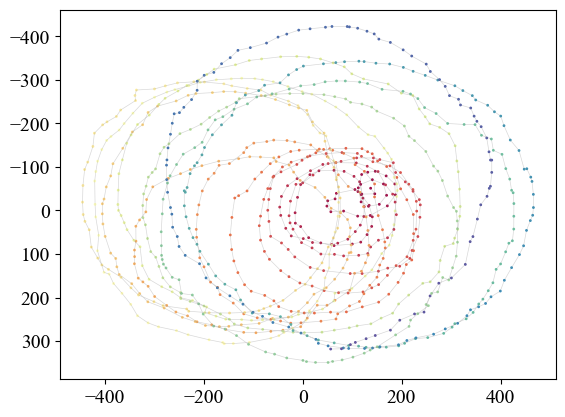

In [4]:
scan_idx = 235
probe_pos_list = ProbePositionList(file_path='data/pos{}.csv'.format(scan_idx),
                                   unit='m', psize_nm=8, convert_to_pixel=True, first_is_x=False)
fig, ax, scat = probe_pos_list.plot(show=False, return_obj=True)
fig.savefig('outputs/test235/path_plot_true.pdf')

In [5]:
recons = tifffile.imread('outputs/pred_test235_model_36SpiralDatasets_model_PtychoNNModel_nLevels_4_batchSizePerProcess_32_learningRatePerProcess_0.0001/pred_phase.tiff')
config_dict = InferenceConfigDict()
config_dict['model_path'] = '../../trained_models/model_36SpiralDatasets_model_PtychoNNModel_nLevels_4_batchSizePerProcess_32_learningRatePerProcess_0.0001/best_model.pth'
config_dict['model'] = (PtychoNNModel, {'n_levels': 4})
# config_dict['dp_data_file_handle'] = NPZFileHandle('data/test{}.npz'.format(scan_idx))
config_dict['dp_data_file_handle'] = VirtualDataFileHandle('', dp_shape=recons.shape[1:], num_dps=recons.shape[0])
# config_dict['dp_data_file_handle'].transform_data((128, 128), discard_len=(64, 64))
config_dict['ptycho_reconstructor'] = VirtualReconstructor(InferenceConfigDict())
config_dict['ptycho_reconstructor'].set_object_image_array(recons)
config_dict['random_seed'] = 196 
config_dict['debug'] = False

Serial correction

In [6]:
config_dict['method'] = 'serial'
config_dict['registration_method'] = 'sift'
config_dict['probe_position_list'] = None
config_dict['central_crop'] = None
config_dict['max_shift'] = 55
config_dict['offset_estimator_order'] = 1
config_dict['offset_estimator_beta'] = 0.5

In [7]:
corrector = PtychoNNProbePositionCorrector(config_dict)
corrector.build()
corrector.run()
probe_pos_list_serial = corrector.new_probe_positions.array

[2023-12-04 10:04:16,402] Random seed is set to 196.
  5%|███████████▏                                                                                                                                                                                                                              | 46/960 [00:04<01:26, 10.54it/s][2023-12-04 10:04:21,451] Large error after applying offset (0.39794280366065216).
[2023-12-04 10:04:21,541] Large error after applying offset (0.38792291918593763).
 10%|██████████████████████▍                                                                                                                                                                                                                   | 92/960 [00:09<01:23, 10.34it/s][2023-12-04 10:04:26,046] Large error after applying offset (0.6342239622692342).
[2023-12-04 10:04:26,144] Large error after applying offset (0.6285828555402534).
 15%|██████████████████████████████████▍                                 

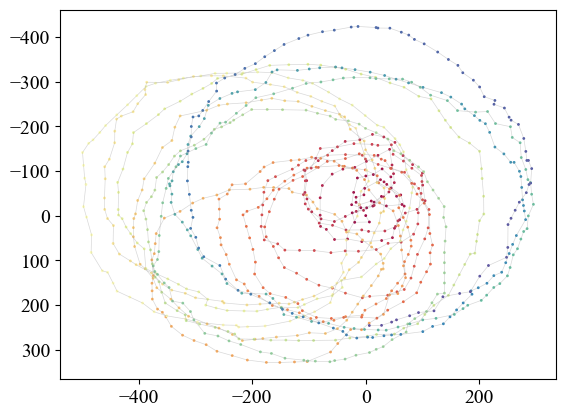

In [8]:
fig, ax, scat = corrector.new_probe_positions.plot(return_obj=True, show=False)
plt.show()
#fig.savefig('outputs/test235/path_plot_serial.pdf')

In [9]:
probe_pos_list = ProbePositionList(position_list=probe_pos_list_serial)
config_dict['probe_position_list'] = probe_pos_list
config_dict['method'] = 'collective'
config_dict['num_neighbors_collective'] = 12
config_dict['debug'] = False
corrector = PtychoNNProbePositionCorrector(config_dict)
corrector.build()
#corrector.run()
corrector.build_linear_system_for_collective_correction()

[2023-12-04 10:08:29,259] Random seed is set to 196.
  0%|                                                                                                                                                                                                                                                   | 0/961 [00:00<?, ?it/s][2023-12-04 10:08:29,396] Large error after applying offset (1.035885920969922).
[2023-12-04 10:08:29,491] Large error after applying offset (1.1938975696064156).
[2023-12-04 10:08:29,771] Large error after applying offset (0.9217939863000468).
[2023-12-04 10:08:29,865] Large error after applying offset (0.42268113364384174).
[2023-12-04 10:08:30,140] Large error after applying offset (1.4023534995549256).
[2023-12-04 10:08:30,234] Large error after applying offset (0.9546684486878393).
[2023-12-04 10:08:30,328] Large error after applying offset (0.6657619922691711).
[2023-12-04 10:08:30,419] Large error after applying offset (1.303043693343084).
  0%|▏              

In [12]:
corrector.solve_linear_system(mode='residue', smooth_constraint_weight=1e-2)

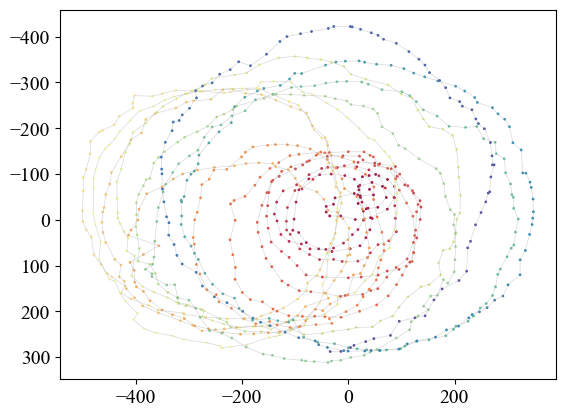

In [14]:
fig, ax, scat = corrector.new_probe_positions.plot(return_obj=True, show=False)
#plt.show()
fig.savefig('outputs/test235/path_plot_collective_iter_1_nn_12_sw_1e-2.pdf', format='pdf')

In [16]:
# 2nd iteration
probe_pos_list = ProbePositionList(position_list=corrector.new_probe_positions.array)
config_dict['probe_position_list'] = probe_pos_list
config_dict['method'] = 'collective'
config_dict['num_neighbors_collective'] = 12
config_dict['debug'] = False
corrector = PtychoNNProbePositionCorrector(config_dict)
corrector.build()
#corrector.run()
corrector.build_linear_system_for_collective_correction()

[2023-12-04 10:26:17,706] Random seed is set to 196.
  0%|▉                                                                                                                                                                                                                                          | 4/961 [00:04<16:49,  1.05s/it][2023-12-04 10:26:22,553] Large error after applying offset (0.578189314809048).
[2023-12-04 10:26:22,911] Large error after applying offset (0.6699464951259265).
  1%|█▏                                                                                                                                                                                                                                         | 5/961 [00:05<15:33,  1.02it/s][2023-12-04 10:26:23,577] Large error after applying offset (0.3105504104842075).
[2023-12-04 10:26:23,778] Large error after applying offset (0.46366351567058967).
  1%|█▍                                                                    

In [23]:
corrector.solve_linear_system(mode='residue', smooth_constraint_weight=1e-3)

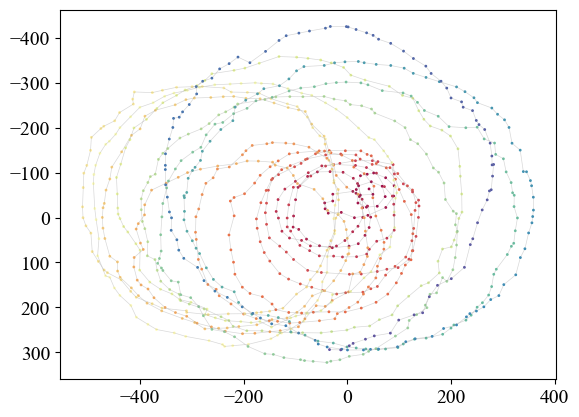

In [24]:
fig, ax, scat = corrector.new_probe_positions.plot(return_obj=True, show=False)
#plt.show()
fig.savefig('outputs/test235/path_plot_collective_iter_2_nn_12_sw_1e-3_1e-2.pdf', format='pdf')

In [20]:
corrector.new_probe_positions.to_csv('outputs/test235/calc_pos_235_collective_niters_2_beta_0p5_nn_12_sw_1e-2_1e-3.csv', psize_nm=8)